Early Spring Data Exploration 
========================

* Frame the problem and look at the big picture
* Get the data



In [187]:
# All of your imports here 
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from IPython.display import display
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.stats import gaussian_kde
import os

In [188]:
# def new_date_features(data):
 ##   data['year'] = data['date'].dt.year
 #   data['month'] = data['date'].dt.month
  #  data['day'] = data['date'].dt.day
 #   return data

def drop_enso_columns(data):

    features_to_drop = [
        # 'global temperature anomalies',
        'Nino 1+2 SST',
        'Nino 1+2 SST Anomalies',
        'Nino 3 SST',
        'Nino 3 SST Anomalies',
        'Nino 3.4 SST',
        'Nino 3.4 SST Anomalies',
        'Nino 4 SST',
        'Nino 4 SST Anomalies',
        'TNI',
        'PNA',
        'OLR',
        'SOI',
        'MEI.v2',
        'Season (2-Month)',
        'Season (3-Month)',
        'Season (12-Month)',
        'ENSO Phase-Intensity'
    ]

    data = data.drop(columns=features_to_drop)

    return data



### **Pivoting The Data**

In [189]:
def pivot_enso():
    data = pd.read_csv('ENSO.csv', parse_dates=['date'])

    # data = drop_enso_columns(data)
    dat = data.copy()
    dat['year'] = dat.date.dt.year  # TODO
    dat['year'] = dat.apply(lambda row: row['year'] + 1 if row['date'].month >= 3 else row['year'], axis=1) # trying to move months after february up one year.
    dat['month'] = dat.date.dt.month
    dat = dat.drop(columns=['date'])
    dat_pivoted = dat.pivot(index='year', columns='month')
    dat_pivoted.columns = ["_".join(str(x) for x in a) for a in dat_pivoted.columns.to_flat_index()]
    return dat_pivoted

def pivot_soil():
    data = pd.read_csv('soil.csv', parse_dates=['day'])

    dat = data.copy()
    dat['year'] = dat.day.dt.year
    dat['day_of_year'] = dat.day.dt.day_of_year
    # holder = dat['day']
    dat = dat.drop(columns=['day']).pivot(index='year', columns='day_of_year')
    dat.columns = ["_".join(str(x) for x in a) for a in dat.columns.to_flat_index()]
    # dat['day_of_year'] = holder.dt.day_of_year

    return dat

def pivot_weather():
    data = pd.read_csv('weather.csv', parse_dates=['date'])

    dat = data.copy()
    dat['year'] = dat.date.dt.year
    dat['day_of_year'] = dat.date.dt.day_of_year
    # holder = dat['date']
    dat = dat.drop(columns=['date']).pivot(index='year', columns='day_of_year')
    dat.columns = ["_".join(str(x) for x in a) for a in dat.columns.to_flat_index()]
    # dat['day_of_year'] = holder.dt.day_of_year

    return dat

#### **Merging The Data**

In [190]:
csv_files = [
    'early_spring.csv',
    'phil_pred.csv',
    'soil.csv',
    'weather.csv',
    'ENSO.csv'
]

def pivot_files():
    enso_pivoted = pivot_enso()
    soil_pivoted = pivot_soil()
    weather_pivoted = pivot_weather()

    return enso_pivoted, soil_pivoted, weather_pivoted

def process_file(df):
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
    elif 'day' in df.columns:
        df['day'] = pd.to_datetime(df['day'])
        df.rename(columns={'day': 'date'}, inplace=True)
    elif 'year' in df.columns:
        df['year'] = pd.to_datetime(df['year'], format='%Y')
        df.rename(columns={'year': 'date'}, inplace=True)
    return df

output_file = 'combined_data.csv'
combined_data = None

enso_pivoted, soil_pivoted, weather_pivoted = pivot_files()
phil_pred = pd.read_csv('phil_pred.csv')
# enso_pivoted = process_file(enso_pivoted)
# soil_pivoted = process_file(soil_pivoted)
# weather_pivoted = process_file(weather_pivoted)
# phil_pred = process_file(phil_pred)

datasets = [enso_pivoted, soil_pivoted, weather_pivoted, phil_pred]

for df in datasets:
    if combined_data is None:
        combined_data = df
    else:
        combined_data = pd.merge(combined_data, df, how='outer', on='year')
        print(f"Processed {df.shape[1]} columns from {df.shape[0]} rows")

combined_data = combined_data.sort_values(by='year')

combined_data.to_csv(output_file, index=False)

print("\nFirst 5 rows of sorted merged data:")
print(combined_data.head())
print("\nShape of sorted merged data:", combined_data.shape)
print("\nColumns in sorted merged data:")
print(combined_data.columns.tolist())
print("\nMerge and sorting completed. Combined data saved to", output_file)

Processed 336 columns from 70 rows
Processed 336 columns from 70 rows
Processed 2 columns from 70 rows

First 5 rows of sorted merged data:
   year  global temperature anomalies_1  global temperature anomalies_2  \
0  1947                             NaN                             NaN   
1  1948                             NaN                             NaN   
2  1949                             NaN                             NaN   
3  1950                           -0.20                           -0.26   
4  1951                           -0.31                           -0.37   

   global temperature anomalies_3  global temperature anomalies_4  \
0                             NaN                             NaN   
1                             NaN                             NaN   
2                             NaN                             NaN   
3                             NaN                             NaN   
4                           -0.08                           -0.1

# Frame the Problem and Look at the Big Picture 


1. **Define the objective in business terms:** We want to predict early spring for Groundhog Day (I think right?). We want to be able to estimate if there will be an early spring based on weather and soil data available before April 1st. Being able to predict this accurately can lead to significant financial gains.

2. **How will your solution be used?** It will be used to make a prediction before April 1st each year. The prediction will be based on daily local weather and soil data collected up to that point. This information will be used to make business decisions that can lead to increased profits if the prediction is correct.

3. **What is the current solution?** Currently, there might be traditional methods or less data-driven approaches to predicting early spring. Our solution aims to improve upon these by incorporating more data and using machine learning techniques.

4. **How should you frame this problem?** <mark>This will be a supervised problem where we are predicting whether there will be an early spring or not. We will want this to be a system that can adapt to climate changes over time. Since it's based on weather data, it's unlikely to be gamed or manipulated.</mark> 

5. **How should performance be measured? Is the performance measure aligned with the business objective?** <mark>Since we are When predicting early spring, both small and large mistakes are equally important up to a point. MAE (Mean Absolute Error) works well because it measures all mistakes the same way.</mark>

6. **What would be the minimum performance needed to reach the business objective?** The prediction accuracy should be significantly better than random guessing (50%) to be profitable. Given the profit/loss percentages, an accuracy above 65% would start to be profitable.

7. **What are comparable problems? Can you reuse experience or tools?** <mark>We can use tools and techniques from other binary classification problems in weather prediction or agricultural forecasting. Time series analysis tools will also be valuable given the nature of the data.</mark> 

8. **Is human expertise available?** idk.

9. **How would you solve the problem manually?** <mark>Collect data and compare it against our collected data if it shows similarities with the temperatures and what nought then we can make a educated guess whether it will be a earle spring.</mark>

10. **List the assumptions you (or others) have made so far. Verify assumptions if possible.** 
    - The local data collected daily is reliable and consistent over the years.
    - Climate change isn't dramatically altering the patterns year over year.
    - The 5-day period before April 1st is the most critical for prediction.


# Get the Data 

1. **List the data you need and how much you need:**
    - Historical weather data (temperature, precipitation, snowfall)
    - Soil temperature and moisture data
    - Early spring occurrence data
    - Groundhog Day predictions (if available)

2. **Find and document where you can get that data:**
    
    - N/A right now

3. **Get access authorizations**: Most of this data should be publicly available, but some soil data might require permission from agricultural departments.

4. **Create a workspace**: This notebook.

5. **Get the data**: 
    - Downloaded early_spring.csv, phil_pred.csv, soil.csv, and weather.csv files
    - These files contain the necessary historical data for our analysis

6. **Convert the data to a format you can easily manipulate**:
   - Data is provided in CSV files, which are easy to use with pandas
   - We've already merged the data into a single combined_data.csv file for easier manipulation

7. **Ensure sensitive information is deleted or protected**: The data appears to be anonymized and doesn't contain sensitive information.

8. **Check the size and type of data (time series, geographical, …)**: <mark>TODO</mark>: Report your information below. At this point, since you don't want to look at the data too closely, this is a quick evaluation about the number of features, the number of samples, and any special considerations about the features such as:
   1. Is it a time series? (Yes, the data is time-based with daily measurements)
   2. Are any of the features not available for the business problem? (We need to ensure we're only using data available before April 1st for predictions)
   3. Which feature(s) will be used as the target/label for the business problem? (The 'early_spring' column from early_spring.csv is likely our target variable)
   4. Should any of the features be stratified during the train/test split to avoid sampling biases? (We might want to stratify by year to ensure we have a good distribution of early spring and non-early spring years in both train and test sets)


#### **Load The Data**

In [192]:
data = pd.read_csv('combined_data.csv') 
data

year  global temperature anomalies_1  global temperature anomalies_2  \
0   1950                           -0.20                           -0.26   
1   1951                           -0.31                           -0.37   
2   1952                            0.14                            0.11   
3   1953                            0.07                            0.15   
4   1954                           -0.20                           -0.06   
..   ...                             ...                             ...   
70  2020                            1.13                            1.19   
71  2021                            0.83                            0.66   
72  2022                            0.92                            0.91   
73  2023                            0.87                            1.00   
74  2024                             NaN                             NaN   

    global temperature anomalies_3  global temperature anomalies_4  \
0                              NaN                             NaN   
1                            -0.08                           -0.16   
2                            -0.16                           -0.09   
3                            -0.03                            0.07   
4                             0.14                            0.26   
..                             ...                             ...   
70                            1.16                            1.02   
71                            1.16                            1.13   
72                            0.88                            0.79   
73                            1.11                            0.89   
74                            1.23                            0.98   

    global temperature anomalies_5  global temperature anomalies_6  \
0                              NaN                             NaN   
1                            -0.02                           -0.02   
2                             0.04                            0.03   
3                             0.08                            0.05   
4                             0.20                            0.21   
..                             ...                             ...   
70                            0.90                            0.90   
71                            0.99                            0.92   
72                            0.81                            0.85   
73                            0.86                            0.89   
74                            0.96                            1.05   

    global temperature anomalies_7  global temperature anomalies_8  \
0                              NaN                             NaN   
1                            -0.09                           -0.09   
2                             0.10                            0.11   
3                             0.07                            0.06   
4                             0.08                            0.10   
..                             ...                             ...   
70                            0.91                            0.91   
71                            0.90                            0.89   
72                            0.91                            0.83   
73                            0.88                            0.92   
74                             NaN                             NaN   

    global temperature anomalies_9  global temperature anomalies_10  \
0                              NaN                              NaN   
1                            -0.06                            -0.14   
2                             0.17                             0.13   
3                             0.09                             0.01   
4                             0.07                             0.13   
..                             ...                              ...   
70                            0.96                             1.00   


#### **Looking At The Features**

In [193]:
data.shape

(75, 902)

In [194]:
empty_columns = data.columns[data.isna().all()].tolist()
for column in empty_columns:
    print(f"Column {column} is empty. Dropping it.")
    data.drop(column, axis=1, inplace=True)

In [195]:
missing_percentage = data.isna().mean() * 100
print(missing_percentage)

year                               0.000000
global temperature anomalies_1     1.333333
global temperature anomalies_2     1.333333
global temperature anomalies_3     1.333333
global temperature anomalies_4     1.333333
                                    ...    
snowdepth_53                      10.666667
snowdepth_54                      10.666667
snowdepth_55                      10.666667
snowdepth_56                      10.666667
prediction                        10.666667
Length: 902, dtype: float64


In [196]:
pd.set_option('display.max_columns', None)

data.head()

year  global temperature anomalies_1  global temperature anomalies_2  \
0  1950                           -0.20                           -0.26   
1  1951                           -0.31                           -0.37   
2  1952                            0.14                            0.11   
3  1953                            0.07                            0.15   
4  1954                           -0.20                           -0.06   

   global temperature anomalies_3  global temperature anomalies_4  \
0                             NaN                             NaN   
1                           -0.08                           -0.16   
2                           -0.16                           -0.09   
3                           -0.03                            0.07   
4                            0.14                            0.26   

   global temperature anomalies_5  global temperature anomalies_6  \
0                             NaN                             NaN   
1                           -0.02                           -0.02   
2                            0.04                            0.03   
3                            0.08                            0.05   
4                            0.20                            0.21   

   global temperature anomalies_7  global temperature anomalies_8  \
0                             NaN                             NaN   
1                           -0.09                           -0.09   
2                            0.10                            0.11   
3                            0.07                            0.06   
4                            0.08                            0.10   

   global temperature anomalies_9  global temperature anomalies_10  \
0                             NaN                              NaN   
1                           -0.06                            -0.14   
2                            0.17                             0.13   
3                            0.09                             0.01   
4                            0.07                             0.13   

   global temperature anomalies_11  global temperature anomalies_12  \
0                              NaN                              NaN   
1                            -0.25                            -0.12   
2                             0.03                             0.21   
3                            -0.08                             0.05   
4                             0.04                             0.07   

   Nino 1+2 SST_1  Nino 1+2 SST_2  Nino 1+2 SST_3  Nino 1+2 SST_4  \
0             NaN             NaN             NaN             NaN   
1             NaN             NaN             NaN             NaN   
2             NaN             NaN             NaN             NaN   
3             NaN             NaN             NaN             NaN   
4             NaN             NaN             NaN             NaN   

   Nino 1+2 SST_5  Nino 1+2 SST_6  Nino 1+2 SST_7  Nino 1+2 SST_8  \
0             NaN             NaN             NaN             NaN   
1             NaN             NaN             NaN             NaN   
2             NaN             NaN             NaN             NaN   
3             NaN             NaN             NaN             NaN   
4             NaN             NaN             NaN             NaN   

   Nino 1+2 SST_9  Nino 1+2 SST_10  Nino 1+2 SST_11  Nino 1+2 SST_12  \
0             NaN              NaN              NaN              NaN   
1             NaN              NaN              NaN              NaN   
2             NaN              NaN              NaN              NaN   
3             NaN              NaN              NaN              NaN   
4             NaN              NaN              NaN              NaN   

   Nino 1+2 SST Anomalies_1  Nino 1+2 SST Anomalies_2  \
0                       NaN                       NaN   
1                       NaN                       NaN   
2                       N

#### **Plotting Histograms For All Columns**

#### **Plotting The Mean Soil Temperature Over Time in 2024**

- This graph shows the average soil temperature over two months in early 2024. The temperature changes a lot, going from as low as -5°C to as high as 8°C. You can see two big spikes in late January and early February, which probably happened during warmer days. Overall, the graph shows normal winter-to-early-spring temperature changes, with cold days followed by warmer ones as the season moves toward spring.


#### **Correlation Heatmap**

- From what we can see the correlation matrix reveals strong relationships within soil temperature measures and within soil moisture measures, but weaker connections between temperature and moisture. For example, there's little correlation between soil conditions and time features like year, month, or day.
- This basically means that soil temperature and moisture levels are generally consistent on their own, but they don't always change in sync with each other and don't follow clear seasonal or time-based patterns

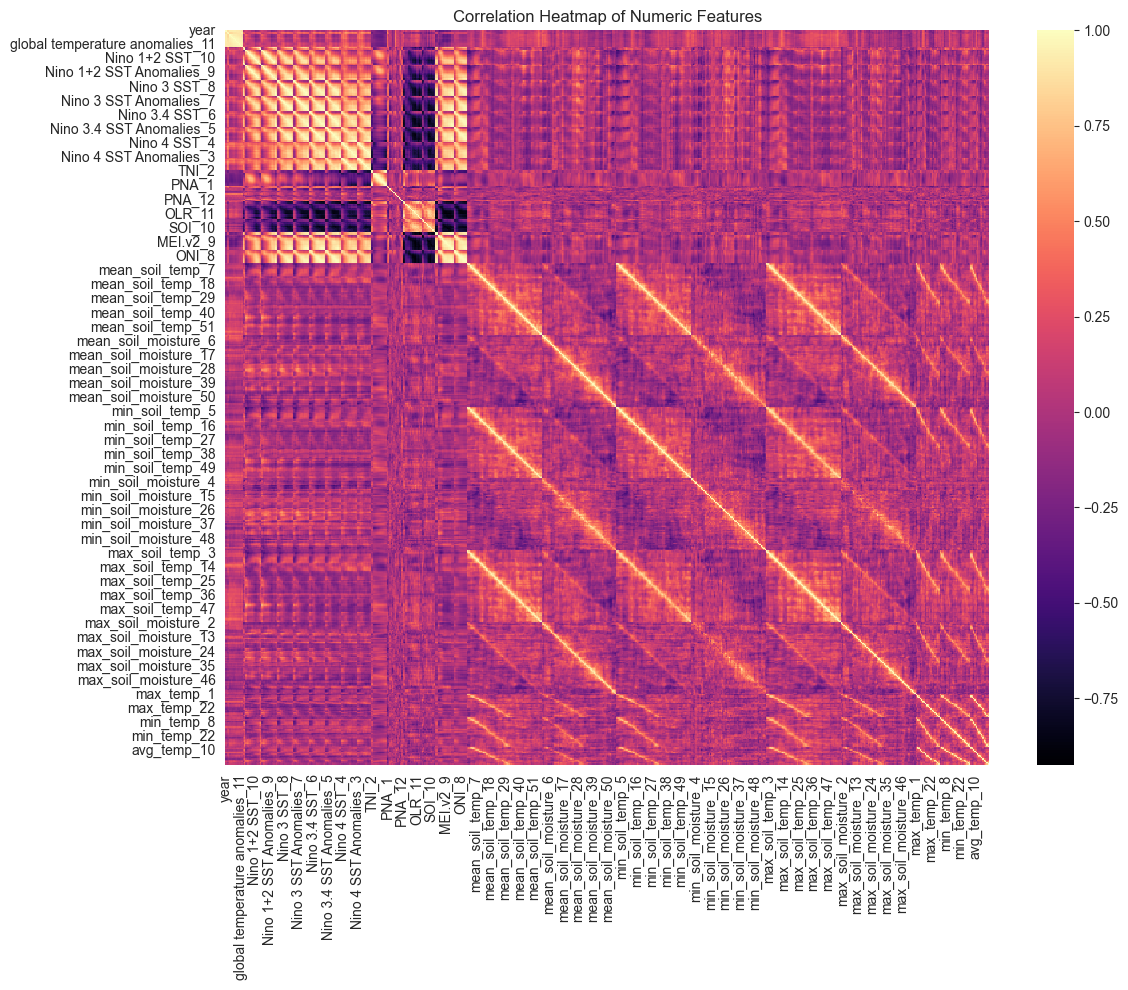

In [197]:
numeric_columns = data.select_dtypes(include=[np.number]).columns
correlation_matrix = data[numeric_columns].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='magma')
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()

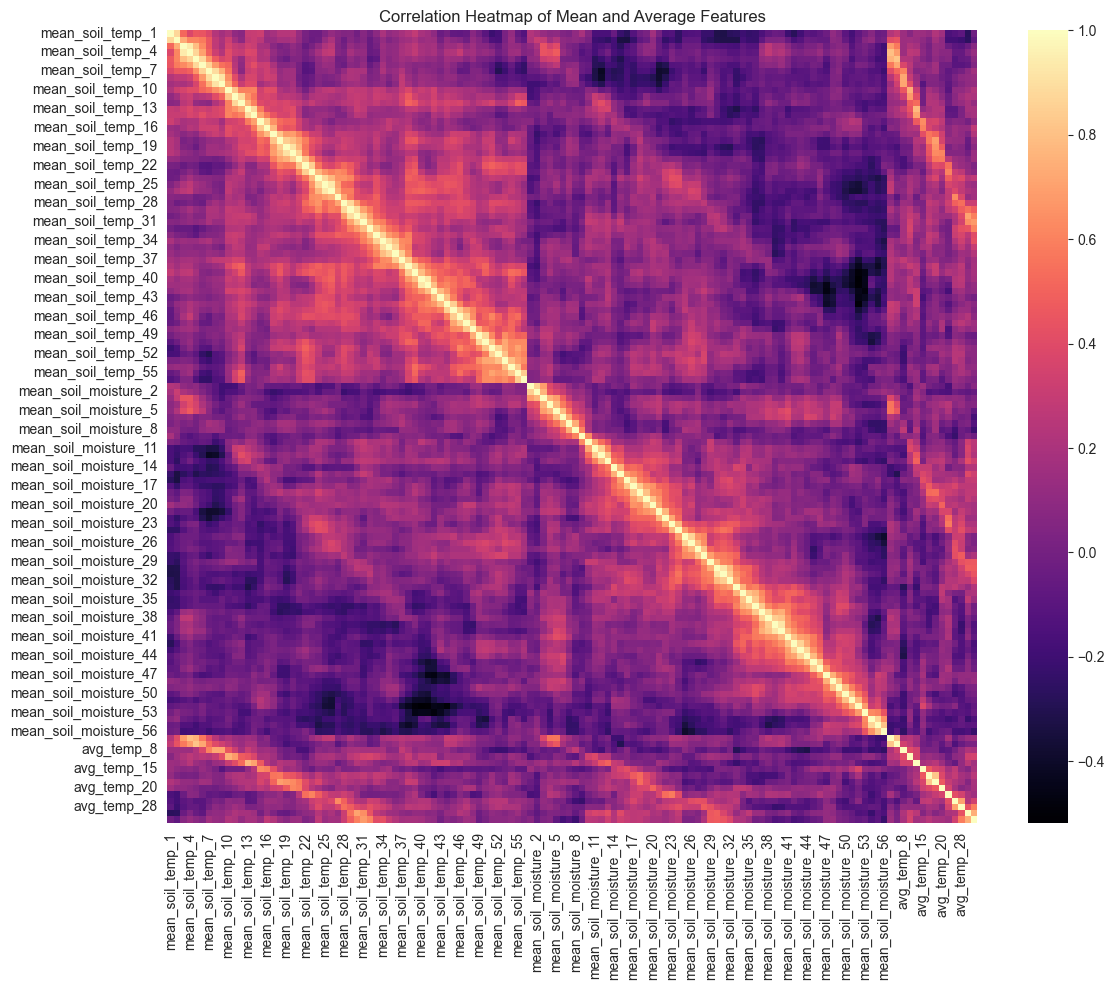

In [198]:
mean_columns = [mean for mean in data.columns if 'mean' in mean]
avg_columns = [avg for avg in data.columns if 'avg' in avg]
numeric_columns = data[mean_columns + avg_columns].select_dtypes(include=[np.number]).columns
correlation_matrix = data[numeric_columns].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='magma')
plt.title('Correlation Heatmap of Mean and Average Features')
plt.tight_layout()

The graph shows soil temperatures from five locations, ranging from -10°C to +12°C over about 80 samples. The lines track closely together, indicating similar temperature changes. Notable spikes occur around samples 5, 50, and 75, with a drop between samples 65 and 70. Overall, soil temperatures are mostly consistent across the area, with minor differences between locations.


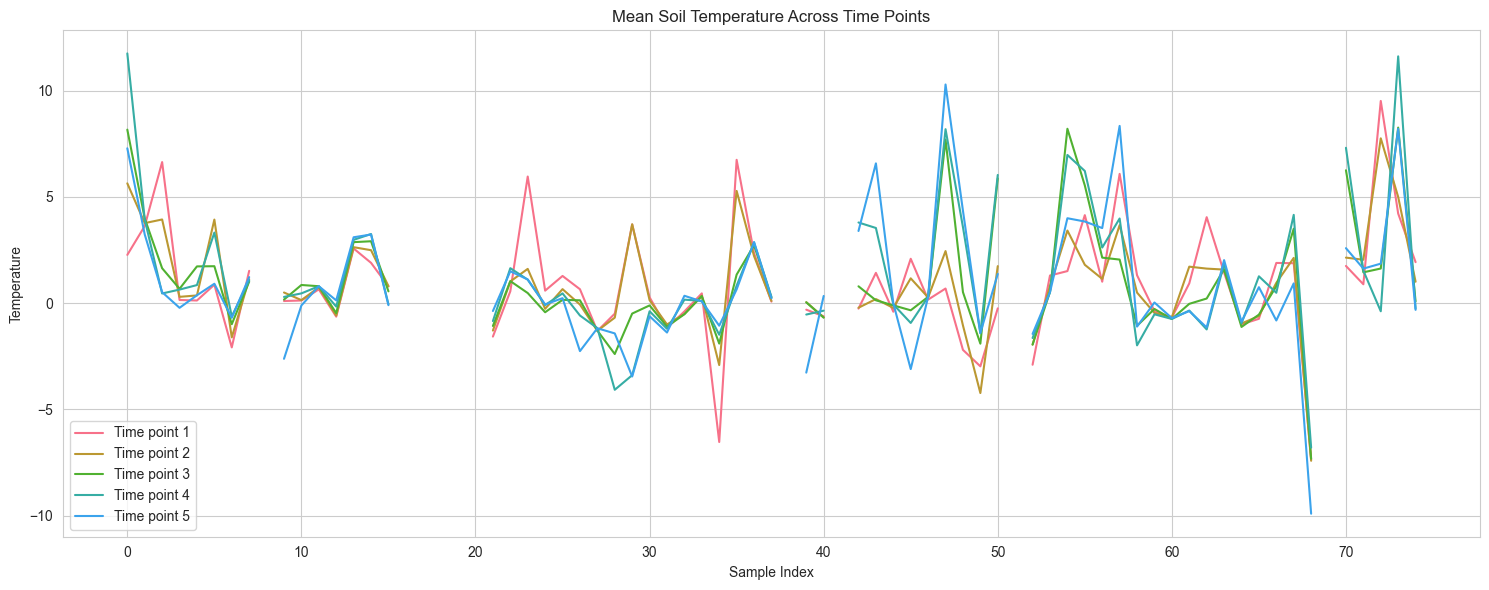

In [199]:
plt.figure(figsize=(15, 6))
soil_temp_cols = [col for col in data.columns if 'soil_temp' in col and 'mean' in col][:5]  # First 5 time points
for col in soil_temp_cols:
    plt.plot(data.index, data[col], label=f'Time point {col.split("_")[-1]}')
plt.title('Mean Soil Temperature Across Time Points')
plt.xlabel('Sample Index')
plt.ylabel('Temperature')
plt.legend()
plt.tight_layout()
plt.show()


This boxplot displays soil moisture levels measured at five different times, ranging from about 0.44 to 0.51. The median moisture level (indicated by the red lines) is stable at around 0.47 across all time points. The similar sizes of the boxes and whiskers suggest that soil moisture is fairly consistent with little variation between measurements.


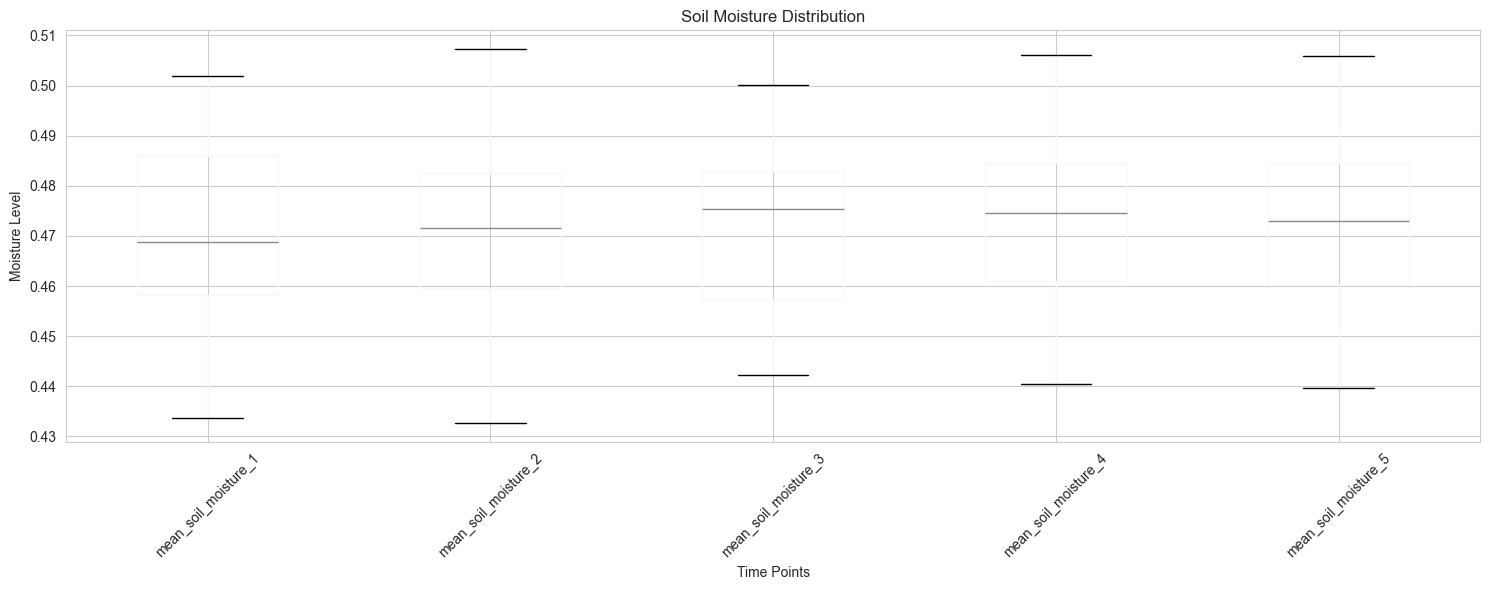

In [200]:
plt.figure(figsize=(15, 6))
moisture_cols = [col for col in data.columns if 'soil_moisture' in col and 'mean' in col][:5]
data[moisture_cols].boxplot()
plt.title('Soil Moisture Distribution')
plt.xlabel('Time Points')
plt.ylabel('Moisture Level')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This scatter plot shows the relationship between soil temperature (x-axis: -7.5°C to 10°C) and soil moisture (y-axis: 0.44 to 0.51), with color intensity indicating data density. Most points cluster around 0°C and 0.47-0.49 moisture levels, but there’s no strong linear relationship, suggesting the two variables are mostly independent.

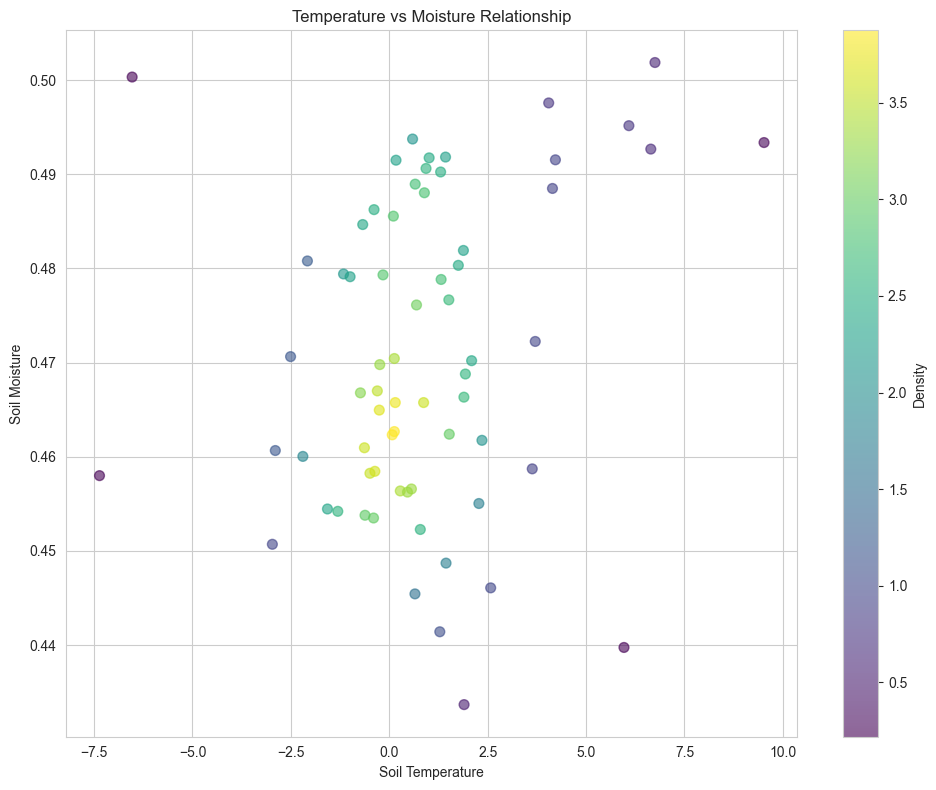

In [201]:
plt.figure(figsize=(10, 8))
if soil_temp_cols and moisture_cols:
    x = data[soil_temp_cols[0]]  # First time point
    y = data[moisture_cols[0]]
    
    # Remove any NaN values
    mask = ~(np.isnan(x) | np.isnan(y))
    x = x[mask]
    y = y[mask]
    
    # Create density scatter plot
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    
    scatter = plt.scatter(x, y, c=z, s=50, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label='Density')
    
plt.title('Temperature vs Moisture Relationship')
plt.xlabel('Soil Temperature')
plt.ylabel('Soil Moisture')
plt.tight_layout()
plt.show()


The graph displays soil temperature changes from 1950 to 2020. The red line shows the average temperature, while the pink area shows how much the temperature can vary. You can see spikes in temperature around 1950, 1990, and 2015. Most of the time, the temperature stayed between -2.5°C and 5°C, but it dropped sharply to -7.5°C close to 2020.


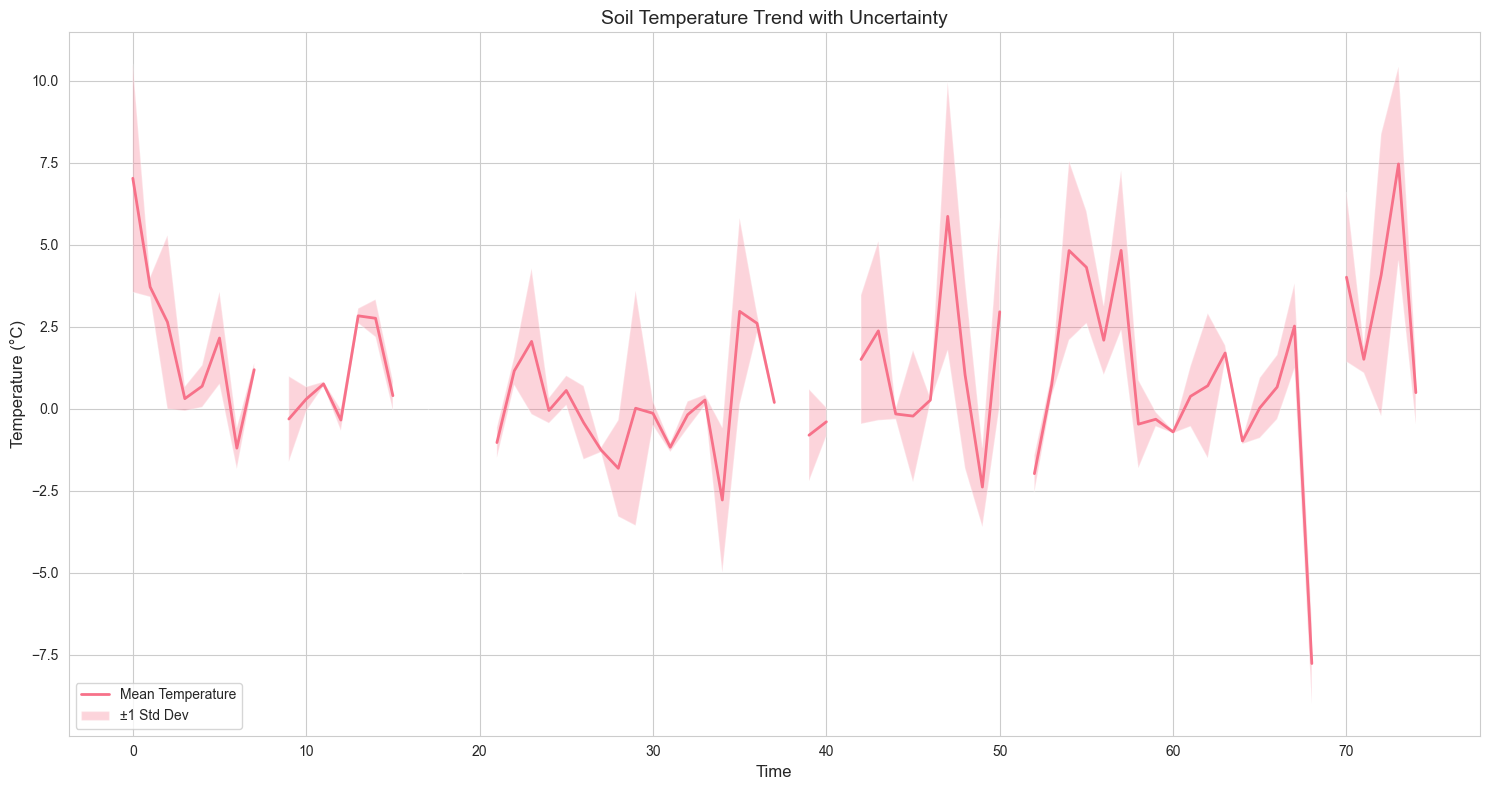

In [202]:
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")
sns.set_palette("husl")

# Calculate mean and std for temperature columns
temp_mean = data[soil_temp_cols].mean(axis=1)
temp_std = data[soil_temp_cols].std(axis=1)

plt.plot(data.index, temp_mean, label='Mean Temperature', linewidth=2)
plt.fill_between(data.index, 
                 temp_mean - temp_std, 
                 temp_mean + temp_std, 
                 alpha=0.3,
                 label='±1 Std Dev')
plt.title('Soil Temperature Trend with Uncertainty', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

This graph shows the relationship between soil temperature (x-axis) and soil moisture (y-axis), with histograms on the sides showing how often each value appears. The red line shows a slight positive trend, meaning that as temperature increases, moisture tends to increase a little too. However, the points are scattered, so the relationship isn't strong. The histograms indicate that most temperatures are around 0°C, while moisture levels are mostly between 0.46 and 0.49.

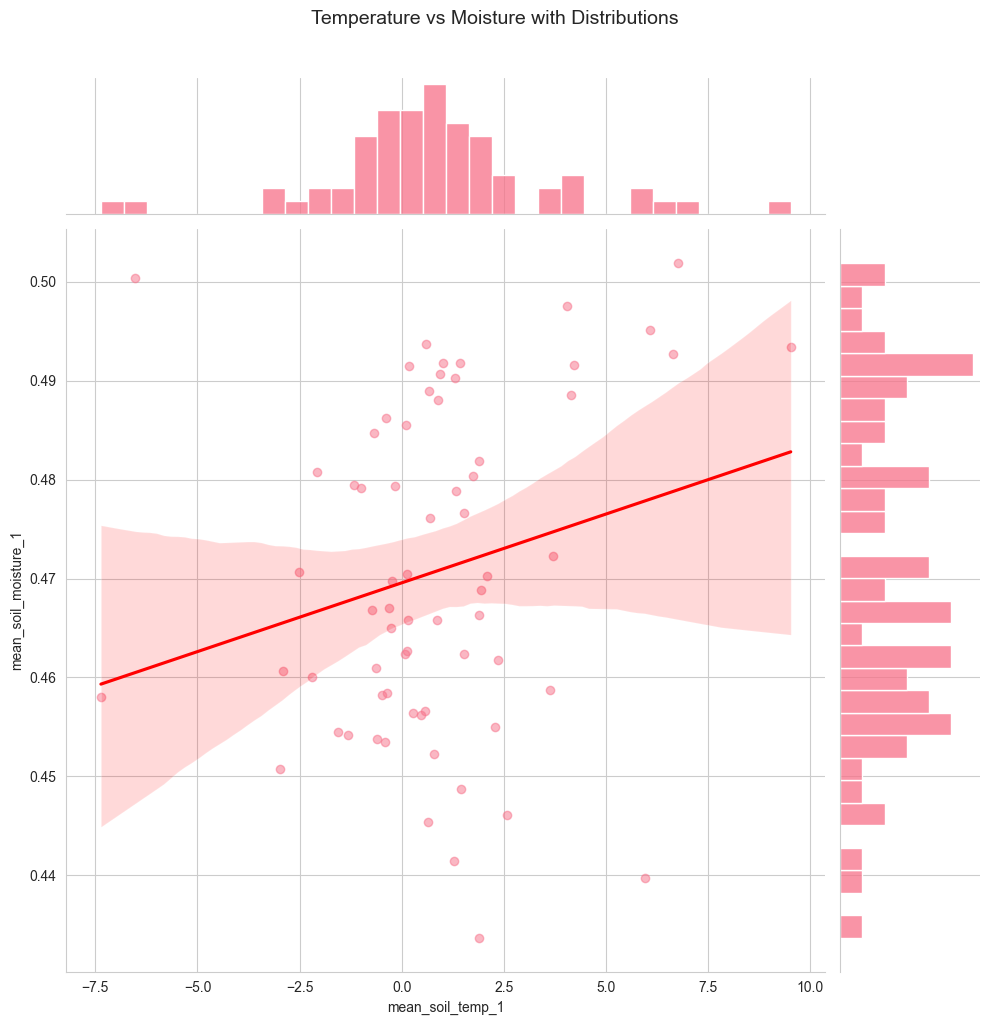

In [203]:
g = sns.JointGrid(data=data, 
                  x=soil_temp_cols[0],
                  y=moisture_cols[0],
                  height=10)
g = g.plot_joint(sns.regplot, 
                 scatter_kws={'alpha':0.5},
                 line_kws={'color': 'red'})
g = g.plot_marginals(sns.histplot, bins=30)
g.fig.suptitle('Temperature vs Moisture with Distributions', y=1.02, fontsize=14)
plt.tight_layout()


This density plot shows how soil temperature and moisture levels are distributed together. The bright yellow area around 0°C and 0.46 moisture indicates where most measurements are found. The colors range from purple (less common) to yellow (most common). There's also a purple spot at -5°C, showing a different group with higher moisture levels.

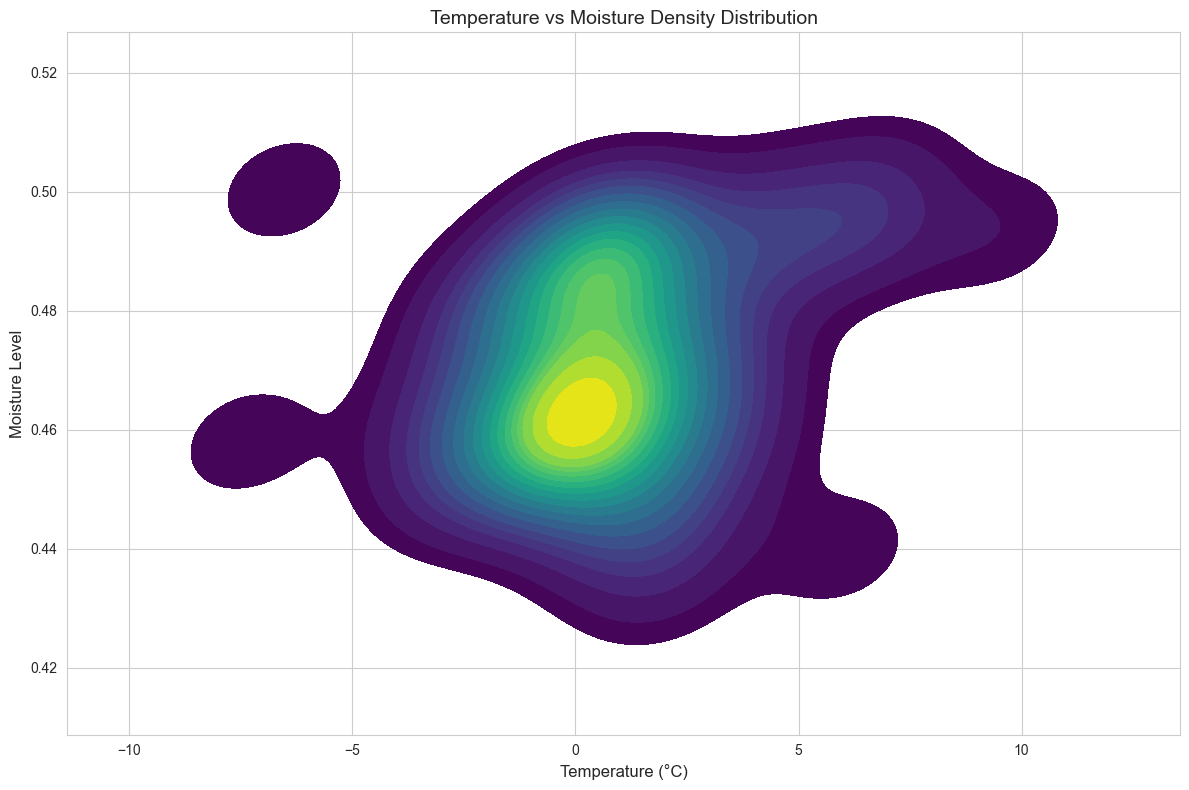

In [204]:
plt.figure(figsize=(12, 8))
sns.kdeplot(data=data,
            x=soil_temp_cols[0],
            y=moisture_cols[0],
            cmap='viridis',
            fill=True,
            levels=20)
plt.title('Temperature vs Moisture Density Distribution', fontsize=14)
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Moisture Level', fontsize=12)
plt.tight_layout()
plt.show()

#### **Splitting The Data**

In [205]:
def split_data():
    train_set, test_set = train_test_split(data, test_size=0.2, random_state=7)
    return train_set, test_set

In [206]:
train_set, test_set = split_data()
data = train_set.copy()

In [207]:
# prints the percentages missing in every column
missing_percentage = data.isna().mean() * 100
print(missing_percentage)

year                              0.000000
global temperature anomalies_1    1.666667
global temperature anomalies_2    1.666667
global temperature anomalies_3    1.666667
global temperature anomalies_4    1.666667
                                    ...   
snowdepth_53                      6.666667
snowdepth_54                      6.666667
snowdepth_55                      6.666667
snowdepth_56                      6.666667
prediction                        6.666667
Length: 902, dtype: float64


# Prepare the Data

Note: the word *optional* simply means not all datasets will require it, it does not mean you can just choose not to do it if it is needed for a particular dataset.

- **A.** Data cleaning: Fix/remove outliers (optional); Fill in missing values (with 0, mean, median…) or drop rows/columns <mark>✓</mark>
- **B.** Feature selection (optional): Drop attributes that provide no useful information for the task <mark>✓</mark>
- **C.** Feature engineering, where appropriate: Discretize continuous features; Decompose features (categorical, date/time, …), Add promising transformations of features ($\log(x)$, $\sqrt{x}$, $x^2$, …); Aggregate features into promising new features <mark>✓</mark>
- **D.** Feature scaling: standardize or normalize features <mark>✓</mark>



In [223]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

class DropSamplesOverThreshold(BaseEstimator, TransformerMixin):
    """Drops samples with missing values over a certain threshold."""
    def __init__(self, threshold=0.5):
        self.threshold = threshold
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # dropping samples with the year being before 1950
        X = X[X['year'] >= 1950]
        return X

class FeatureSelector(BaseEstimator, TransformerMixin):
    """Selects specific feature columns based on a prefix and range."""
    def __init__(self, prefix, lookback=12):
        self.prefix = prefix
        self.lookback = lookback
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        selected_columns = [f'{self.prefix}_{i}' for i in range(1, self.lookback + 1)]
        return X[selected_columns]

class FeatureAggregator(BaseEstimator, TransformerMixin):
    """Aggregates features using statistical measures like mean, min, max."""
    def __init__(self, feature_types=['temp', 'precipitation', 'snowfall']):
        self.feature_types = feature_types
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        result = pd.DataFrame(index=X.index)
        
        for feature in self.feature_types:
            # Find all columns that correspond to the feature
            mean_cols = [col for col in X.columns if col.startswith(f'mean_{feature}')]
            min_cols = [col for col in X.columns if col.startswith(f'min_{feature}')]
            max_cols = [col for col in X.columns if col.startswith(f'max_{feature}')]
            
            if mean_cols:
                result[f'{feature}_mean'] = X[mean_cols].mean(axis=1)
            if min_cols:
                result[f'{feature}_min'] = X[min_cols].min(axis=1)
            if max_cols:
                result[f'{feature}_max'] = X[max_cols].max(axis=1)
                
        return result

# Create a new preprocessing pipeline
def create_new_pipeline():
    # Feature selection
    temp_selector = FeatureSelector(prefix='temp', lookback=12)
    precip_selector = FeatureSelector(prefix='precipitation', lookback=12)
    snow_selector = FeatureSelector(prefix='snowfall', lookback=12)

    # Column Transformer

    data_cleaner = ColumnTransformer([
        ('drop_samples_over_threshold', DropSamplesOverThreshold(), data)
    ])

    preprocessor = ColumnTransformer([
        ('temp_features', temp_selector, slice(None)),
        ('precip_features', precip_selector, slice(None)),
        ('snow_features', snow_selector, slice(None)),
    ])

    # Create the main pipeline
    pipeline = Pipeline([
        ('data_cleaner', data_cleaner),
        ('feature_selection', preprocessor),
        ('aggregator', FeatureAggregator()),
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    
    return pipeline

# Function to prepare data for training or prediction
def prepare_new_data(data):
    # Remove columns related to predictions or irrelevant targets
    feature_data = data.drop(columns=[col for col in data.columns if col.startswith('prediction')])

    # Create and fit preprocessing pipeline
    pipeline = create_new_pipeline()
    X_processed = pipeline.fit_transform(feature_data)

    return X_processed, pipeline
Pipeline = create_new_pipeline()
Pipeline


Pipeline(steps=[('data_cleaner',
                 ColumnTransformer(transformers=[('drop_samples_over_threshold',
                                                  DropSamplesOverThreshold(),
                                                      year  global temperature anomalies_1  global temperature anomalies_2  \
17  1967                           -0.11                           -0.15   
18  1968                           -0.19                           -0.10   
45  1995                            0.55                            0.77   
37  1987                            0.30                            0.36   
26  1976                           -0.01                           -0.08   
53  2003                            0.71                            0.57   
21  1971                           -0.02                           -0.15   
72  2022                            0.92                            0.91   
33  1983                            0.51                            0.46   
30  1980                            0.35                            0.42   
36  1986                            0.23                            0.38   
40  199...
                 ColumnTransformer(transformers=[('temp_features',
                                                  FeatureSelector(prefix='temp'),
                                                  slice(None, None, None)),
                                                 ('precip_features',
                                                  FeatureSelector(prefix='precipitation'),
                                                  slice(None, None, None)),
                                                 ('snow_features',
                                                  FeatureSelector(prefix='snowfall'),
                                                  slice(None, None, None))])),
                ('aggregator', FeatureAggregator()),
                ('imputer', SimpleImputer()), ('scaler', StandardScaler())])

In [220]:
preprocessor = prepare_new_data(data)
preprocessor

ValueError: No valid specification of the columns. Only a scalar, list or slice of all integers or all strings, or boolean mask is allowed

In [217]:
preprocessor.fit(data)

AttributeError: 'numpy.ndarray' object has no attribute 'index'